# Drug Repurposing (dummy example)

This notebook assumes that you have read **NORDic Drug Simulation (DS)**. This vignette displays some examples of what can be achieved using **NORDic (version 2.2.1)** in order to use bandit algorithms to output drug recommendations using **NORDic DS** simulations. These simulations, as you might have noticed, can be rather time-consuming when handling a large number (i.e., ~100) nodes in the network. The idea behind the use of bandit algorithms is to exploit the information from drug signatures to selectively test drugs which are the most informative about the top treatments. 

## Installation

In [1]:
import NORDic

## Drug recommendation using bandit algorithms

In [2]:
from subprocess import call as sbcall
save_folder="MODELS/dummy2/"
sbcall("mkdir -p "+save_folder, shell=True)

0

In [3]:
import pandas as pd
import numpy as np
nbseed=12345
np.random.seed(nbseed)

## List of input nodes for each edge
source = list(map(lambda x: "X%d" % x,[1,1,2]))
## List of target nodes for each edge
target = list(map(lambda x : "X%d" % x,[2,3,3]))

## List of all genes
genes = list(sorted(list(set(source+target))))

## Create the network (adjacency matrix)
influences = pd.DataFrame([[0,1,-1],[0,0,1],[0,0,0]], index=genes, columns=genes).astype(int)
influences

,X1,X2,X3
X1,0,1,-1
X2,0,0,1
X3,0,0,0


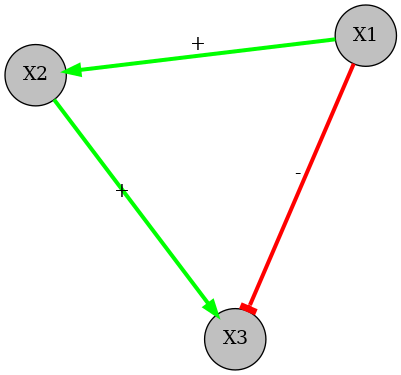

In [4]:
from NORDic.UTILS.utils_plot import influences2graph

influences2graph(influences, save_folder+"example", optional=False, 
                 compile2png=True, engine="sfdp")
from IPython.display import Image
Image(filename=save_folder+'example.png') 

In [5]:
## Gene regulatory functions (for each node in the network)

grfs = {}
for si, s in enumerate(source):
    t = target[si]
    grf, sign = grfs.get(t, {}), influences.loc[s][t]
    if (sign==0):
        continue
    grf.update({s: sign})
    grfs.update({t: grf})
grfs

{'X2': {'X1': 1}, 'X3': {'X1': -1, 'X2': 1}}

In [6]:
with open(save_folder+"example.bnet", "w") as f:
    network = []
    for g in genes:
        if (g in grfs):
            activators = [r for r in grfs[g] if (grfs[g][r]>0)]
            inhibitors = ["!"+r for r in grfs[g] if (grfs[g][r]<0)]
            ## note that the separator is ", "
            network += [g+", "+("("+"|".join(activators)+")" if (len(activators)>0) else "")
                        +("&" if ((len(activators)>0) and (len(inhibitors)>0)) else "")
                        +("("+"&".join(inhibitors)+")" if (len(inhibitors)>0) else "")] 
        else:
            network += [g+", 1"]
    f.write("\n".join(network))
    
## Print the resulting network
with open(save_folder+"example.bnet", "r") as f:
    network = f.read()
print("\n".join([" <- ".join(s.split(", ")) for s in network.split("\n")]))

X1 <- 1
X2 <- (X1)
X3 <- (X2)&(!X1)


In [7]:
import mpbn
import mpbn_sim
from tqdm import tqdm
from multiprocessing import cpu_count
import os

njobs=max(1,cpu_count()-2)
SIMU_params = {
    'nb_sims': 1000,
    'rates': "nexponential",
    #weighting vector W=(W1, W2, ..., Wn) weight of a transition changing n components at a time
    #rates="uniform": W=(1,1,...,1)
    #rates="fully_asynchronous": 1 component at a time is changed, meaning W=(1, 0, ..., 0)
    #rates="reciprocal": undocumented
    #rates="nexponential": (sampling weight from an exponentially decreasing distr.)
    'thread_count': njobs,
    'depth': "nexponential", 
    #depth="constant_unitary" (depth=1): asynchronous transitions
    #depth=2: target expression can change while regulator expression changes
    #depth=3: target of target expression can change while target expression changes, etc.
    #depth="constant_maximum" (depth=N, where N is the number of nodes in the network)
    #depth="nexponential" (sampling depth from an exponentially decreasing distr.)
}
network_name = save_folder+"example.bnet"
assert SIMU_params["depth"] in ["constant_maximum", "constant_unitary", "nexponential"]
assert SIMU_params["rates"] in ["fully_asynchronous", "uniform", "reciprocal", "nexponential"]

## Create the mutated networks
def patch_model(f, patch):
    f = mpbn.MPBooleanNetwork(f)
    for i, fi in patch.items():
        f[i] = fi
    return f
experiments = [{"name": "mpsim", "rates": SIMU_params["rates"], "depth": SIMU_params["depth"]}]
nb_sims = SIMU_params["nb_sims"]

if (not os.path.exists(save_folder+"phenotypes.csv")):
    f_wildtype = mpbn.load(network_name)
    ## Initial states drawn at random
    state_len = 10
    states = pd.DataFrame(
      [np.random.choice([0,1], p=[0.5,0.5], size=len(genes)).tolist() for _ in range(state_len)]
      , columns=genes, index=range(state_len)).T
    A_WT, A_mut = [], []
    for state in tqdm(states.columns):
        x0 = f_wildtype.zero()
        for i in list(states.loc[states[state]==1].columns):
            x0[i] = 1
        x0["X2"] = 1 # in wild type
        f_mutant = patch_model(f_wildtype, {"X2": 0})
        ## Get the reachable attractors from initial state in the presence/absence of X0 knockout
        A_WT += [a for a in tqdm(list(f_wildtype.attractors(reachable_from=x0)))]
        A_mut += [a for a in tqdm(list(f_mutant.attractors(reachable_from=x0)))]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3751.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2868.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2894.62it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3695.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3758.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████

In [8]:
for a in A_WT:
    a.update({"annotation": 1})
for a in A_mut:
    a.update({"annotation": 2})
controls = {"Control%d" % (i+1): a for i,a in enumerate(A_WT)}
patients = {"Case%d" % (i+1): a for i,a in enumerate(A_mut)}
controls.update(patients)
states = pd.DataFrame(controls)
states

,Control1,Control2,Control3,Control4,Control5,Control6,Control7,Control8,Control9,Control10,Case1,Case2,Case3,Case4,Case5,Case6,Case7,Case8,Case9,Case10
X1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
X2,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
X3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
annotation,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2


In [9]:
targets = pd.DataFrame({
    "T1": {"X1": 1, "X2": 1}, #expected treatment
    "T2": {"X1": -1, "X2": 1}, #expected treatment
    "T3": {"X3": -1, "X2": 1}, #expected treatment
    "T4": {"X2": -1, "X3": 1},
    "T5": {"X2": 1}, #expected treatment
    "T6": {"X3": -1, "X1": -1},
})
all_genes = pd.DataFrame({"One": {g: 0 for g in genes}})
targets = targets.join(all_genes, how="outer").fillna(0)[[c for c in targets.columns if (c!="One")]].astype(int)
targets

,T1,T2,T3,T4,T5,T6
X1,1,-1,0,0,0,-1
X2,1,1,1,-1,1,0
X3,0,0,-1,1,0,-1


In [10]:
## Define the function which determines whether a state is closer to controls/patients
dfdata = states.loc[[i for i in states.index if (i != "annotation")]]
samples = states.loc["annotation"]
from NORDic.NORDic_DS.functions import compute_frontier
## compute_frontier fits a SVM model to the data
frontier = compute_frontier(dfdata, samples)
score = lambda attrs : (frontier.predict(attrs.values.T)==1).astype(int)

## Patient profiles
patients = states[[c for c in states.columns if ("Case" in c)]].loc[[i for i in states.index if (i != "annotation")]]

<NORD_DS> Accuracy of the model 1.00


In [11]:
from NORDic.NORDic_DR.functions import adaptive_testing

BANDIT_args = {
    'bandit': 'LinGapE', 
    #type of algorithm, (greedy) LinGapE is faster but more prone to errors 
    #(assumes that the model is linear)
    'seed': nbseed,
    'delta': 0.1, #error rate
    'nsimu': 1, #number of repeats
    'm': 4, #number of recommendations to make

    'c': 0, #nonnegative parameter to tune for MisLid (if the model is linear, set to 0
    ## To speed up the algorithm, decrease c
    ## To ensure correctness of the recommendation, increase c
    'sigma': 1,
    'beta': "heuristic",
    'epsilon': 0.1,
    'tracking_type': "D",
    'gain_type': "empirical",
    'learner': "AdaHedge"
}
recommendation = adaptive_testing(network_name, targets, targets, score, patients, 
        SIMU_params, BANDIT_args, reward_fname=None, quiet=False).T

domRec ignored: No domain atoms found.


	<NORD_DS> Initial state Case3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3506.94it/s]


Drug T1 (1/1) in state Case3 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 40558.77it/s]


	<NORD_DS> Initial state Case6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3600.26it/s]


Drug T2 (1/1) in state Case6 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 44413.31it/s]
domRec ignored: No domain atoms found.


	<NORD_DS> Initial state Case2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3650.40it/s]


Drug T3 (1/1) in state Case2 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 43164.60it/s]
domRec ignored: No domain atoms found.


	<NORD_DS> Initial state Case5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3512.82it/s]


Drug T4 (1/1) in state Case5 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 39712.39it/s]
domRec ignored: No domain atoms found.


	<NORD_DS> Initial state Case10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3551.49it/s]


Drug T5 (1/1) in state Case10 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 41337.04it/s]


	<NORD_DS> Initial state Case6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3518.71it/s]


Drug T6 (1/1) in state Case6 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 46841.75it/s]


	<NORD_DS> Initial state Case3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7108.99it/s]


Drug T6 (1/1) in state Case3 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 18533.28it/s]


	<NORD_DS> Initial state Case2


domRec ignored: No domain atoms found.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


Drug T1 (1/1) in state Case2 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 40916.05it/s]


	<NORD_DS> Initial state Case7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3692.17it/s]


Drug T6 (1/1) in state Case7 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 38878.99it/s]


	<NORD_DS> Initial state Case10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3334.10it/s]


Drug T2 (1/1) in state Case10 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 38258.38it/s]
domRec ignored: No domain atoms found.


	<NORD_DS> Initial state Case8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3480.75it/s]


Drug T3 (1/1) in state Case8 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 43086.56it/s]
domRec ignored: No domain atoms found.


	<NORD_DS> Initial state Case1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3504.01it/s]


Drug T1 (1/1) in state Case1 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 37575.63it/s]


	<NORD_DS> Initial state Case3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3165.51it/s]


Drug T2 (1/1) in state Case3 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 43027.77it/s]


	<NORD_DS> Initial state Case10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3816.47it/s]


Drug T6 (1/1) in state Case10 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 48128.52it/s]


	<NORD_DS> Initial state Case7


domRec ignored: No domain atoms found.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2576.35it/s]


Drug T1 (1/1) in state Case7 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 41415.82it/s]


	<NORD_DS> Initial state Case8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3521.67it/s]


Drug T2 (1/1) in state Case8 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 45987.15it/s]


	<NORD_DS> Initial state Case8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3572.66it/s]


Drug T6 (1/1) in state Case8 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 45720.46it/s]
domRec ignored: No domain atoms found.


	<NORD_DS> Initial state Case8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3292.23it/s]


Drug T1 (1/1) in state Case8 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 35509.44it/s]


	<NORD_DS> Initial state Case9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]


Drug T2 (1/1) in state Case9 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 27103.74it/s]


	<NORD_DS> Initial state Case5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3492.34it/s]


Drug T6 (1/1) in state Case5 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 27854.69it/s]


	<NORD_DS> Initial state Case4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3600.26it/s]


Drug T6 (1/1) in state Case4 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 17789.66it/s]
domRec ignored: No domain atoms found.


	<NORD_DS> Initial state Case6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3584.88it/s]


Drug T1 (1/1) in state Case6 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 28779.95it/s]


	<NORD_DS> Initial state Case4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3328.81it/s]


Drug T2 (1/1) in state Case4 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 40590.96it/s]


	<NORD_DS> Initial state Case9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3548.48it/s]


Drug T6 (1/1) in state Case9 - nexponential_depth{}	nexponential_rates{}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 41085.18it/s]


It. #1: 41 samples (running avg. 41)
<NORDic DR> Avg. #samples = 41, avg. runtime 2.0559465885162354 sec (over 1 iterations)


In [12]:
recommendation

,Frequency
T1,1.0
T2,1.0
T3,1.0
T4,0.0
T5,1.0
T6,0.0


In [13]:
## "true" scores
from NORDic.NORDic_DS.functions import simulate

scores = simulate(network_name, targets, patients, score,
        simu_params=SIMU_params, nbseed=nbseed)

domRec ignored: No domain atoms found.
100%|██████████| 1000/1000 [00:00<00:00, 42808.63it/s]domRec ignored: No domain atoms found.

100%|██████████| 1000/1000 [00:00<00:00, 40504.72it/s]domRec ignored: No domain atoms found.

100%|██████████| 1000/1000 [00:00<00:00, 41122.24it/s]domRec ignored: No domain atoms found.

  0%|          | 0/1000 [00:00<?, ?it/s]

	<NORD_DS> Initial state Case2
Drug T1 (1/6) in state Case2 - nexponential_depth{}	nexponential_rates{}
Drug T2 (2/6) in state Case2 - nexponential_depth{}	nexponential_rates{}
Drug T3 (3/6) in state Case2 - nexponential_depth{}	nexponential_rates{}
Drug T4 (4/6) in state Case2 - nexponential_depth{}	nexponential_rates{}
Drug T5 (5/6) in state Case2 - nexponential_depth{}	nexponential_rates{}
Drug T6 (6/6) in state Case2 - nexponential_depth{}	nexponential_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 27050.08it/s]domRec ignored: No domain atoms found.

  0%|          | 0/1000 [00:00<?, ?it/s]domRec ignored: No domain atoms found.


	<NORD_DS> Initial state Case1
Drug T1 (1/6) in state Case1 - nexponential_depth{}	nexponential_rates{}
Drug T2 (2/6) in state Case1 - nexponential_depth{}	nexponential_rates{}
Drug T3 (3/6) in state Case1 - nexponential_depth{}	nexponential_rates{}
	<NORD_DS> Initial state Case3
Drug T1 (1/6) in state Case3 - nexponential_depth{}	nexponential_rates{}
Drug T4 (4/6) in state Case1 - nexponential_depth{}	nexponential_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 41372.92it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 17697.49it/s]domRec ignored: No domain atoms found.


100%|██████████| 1000/1000 [00:00<00:00, 41577.57it/s]domRec ignored: No domain atoms found.
domRec ignored: No domain atoms found.

100%|██████████| 1000/1000 [00:00<00:00, 21067.27it/s]

	<NORD_DS> Initial state Case5
Drug T1 (1/6) in state Case5 - nexponential_depth{}	nexponential_rates{}
Drug T2 (2/6) in state Case3 - nexponential_depth{}	nexponential_rates{}
Drug T2 (2/6) in state Case5 - nexponential_depth{}	nexponential_rates{}
Drug T3 (3/6) in state Case5 - nexponential_depth{}	nexponential_rates{}
Drug T5 (5/6) in state Case1 - nexponential_depth{}	nexponential_rates{}
	<NORD_DS> Initial state Case4
Drug T1 (1/6) in state Case4 - nexponential_depth{}	nexponential_rates{}
Drug T3 (3/6) in state Case3 - nexponential_depth{}	nexponential_rates{}
Drug T4 (4/6) in state Case5 - nexponential_depth{}	nexponential_rates{}
	<NORD_DS> Initial state Case9
	<NORD_DS> Initial state Case6
Drug T1 (1/6) in state Case6 - nexponential_depth{}	nexponential_rates{}
Drug T1 (1/6) in state Case9 - nexponential_depth{}	nexponential_rates{}
Drug T4 (4/6) in state Case3 - nexponential_depth{}	nexponential_rates{}
Drug T6 (6/6) in state Case1 - nexponential_depth{}	nexponential_rates{}


domRec ignored: No domain atoms found.
100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]

100%|██████████| 1000/1000 [00:00<00:00, 23605.01it/s]domRec ignored: No domain atoms found.
domRec ignored: No domain atoms found.

100%|██████████| 1000/1000 [00:00<00:00, 25001.66it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 14768.68it/s]


100%|██████████| 1/1 [00:00<00:00, 15947.92it/s]domRec ignored: No domain atoms found.

  0%|          | 0/1000 [00:00<?, ?it/s]domRec ignored: No domain atoms found.
domRec ignored: No domain atoms found.
100%|██████████| 1000/1000 [00:00<00:00, 26398.36it/s]

100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]domRec ignored: No domain atoms found.
domRec ignored: No domain atoms found.

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]

100%|██████████| 1000/1000 [00:00<00:00, 25740.93it/s]domRec ignored: No domain atoms found.
domRec ignored: N

Drug T5 (5/6) in state Case5 - nexponential_depth{}	nexponential_rates{}
Drug T2 (2/6) in state Case9 - nexponential_depth{}	nexponential_rates{}
Drug T3 (3/6) in state Case4 - nexponential_depth{}	nexponential_rates{}
Drug T5 (5/6) in state Case3 - nexponential_depth{}	nexponential_rates{}
Drug T2 (2/6) in state Case6 - nexponential_depth{}	nexponential_rates{}
Drug T2 (2/6) in state Case7 - nexponential_depth{}	nexponential_rates{}
Drug T2 (2/6) in state Case8 - nexponential_depth{}	nexponential_rates{}
Drug T6 (6/6) in state Case5 - nexponential_depth{}	nexponential_rates{}
Drug T4 (4/6) in state Case4 - nexponential_depth{}	nexponential_rates{}
Drug T3 (3/6) in state Case6 - nexponential_depth{}	nexponential_rates{}
Drug T6 (6/6) in state Case3 - nexponential_depth{}	nexponential_rates{}
Drug T3 (3/6) in state Case9 - nexponential_depth{}	nexponential_rates{}
Drug T3 (3/6) in state Case7 - nexponential_depth{}	nexponential_rates{}
Drug T3 (3/6) in state Case8 - nexponential_depth{}

  0%|          | 0/1000 [00:00<?, ?it/s]domRec ignored: No domain atoms found.


100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]domRec ignored: No domain atoms found.
domRec ignored: No domain atoms found.

100%|██████████| 1000/1000 [00:00<00:00, 25815.39it/s]
domRec ignored: No domain atoms found.
domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 14315.03it/s]
domRec ignored: No domain atoms found.
100%|██████████| 1000/1000 [00:00<00:00, 40226.57it/s]domRec ignored: No domain atoms found.

  0%|          | 0/1000 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

100%|██████████| 1000/1000 [00:00<00:00, 43086.11it/s]
domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 15534.46it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

100%|██████████| 1000/1000 [00:00<00:00, 27005.32it/s]

Drug T5 (5/6) in state Case9 - nexponential_depth{}	nexponential_rates{}
Drug T5 (5/6) in state Case6 - nexponential_depth{}	nexponential_rates{}
Drug T6 (6/6) in state Case4 - nexponential_depth{}	nexponential_rates{}
Drug T5 (5/6) in state Case7 - nexponential_depth{}	nexponential_rates{}
Drug T3 (3/6) in state Case10 - nexponential_depth{}	nexponential_rates{}
Drug T5 (5/6) in state Case8 - nexponential_depth{}	nexponential_rates{}
Drug T4 (4/6) in state Case10 - nexponential_depth{}	nexponential_rates{}
Drug T6 (6/6) in state Case9 - nexponential_depth{}	nexponential_rates{}
Drug T6 (6/6) in state Case6 - nexponential_depth{}	nexponential_rates{}
Drug T6 (6/6) in state Case8 - nexponential_depth{}	nexponential_rates{}
Drug T5 (5/6) in state Case10 - nexponential_depth{}	nexponential_rates{}
Drug T6 (6/6) in state Case7 - nexponential_depth{}	nexponential_rates{}
Drug T6 (6/6) in state Case10 - nexponential_depth{}	nexponential_rates{}


100%|██████████| 1000/1000 [00:00<00:00, 47532.91it/s]

In [14]:
ground_truth = scores.mean(axis=0).sort_values(ascending=False)

In [15]:
recommendation.join(pd.DataFrame(ground_truth, columns=["Truth"]))

,Frequency,Truth
T1,1.0,1.0
T2,1.0,1.0
T3,1.0,1.0
T4,0.0,0.0
T5,1.0,1.0
T6,0.0,0.0


Here, for the sake of simplicity, we have selected as features the target indicators. However, adequate feature selection is crucial (removing collinearity, dimension reduction, e.g., by performing a Principal Component Analysis) in order to fully benefit from the speed-up incurred by the use of bandit algorithms, especially in large drug libraries. 